In [13]:
print('Importing Libraries')
import pandas as pd
from sklearn.model_selection import train_test_split ,cross_val_score
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print('Importing Libraries Finished')

Importing Libraries
Importing Libraries Finished


# random seed for reproducibility

In [14]:
random_seed = 42
np.random.seed(random_seed)

# Load your dataset

In [15]:
print("Loading Dataset ...")
your_dataset_path = '/kaggle/input/ransomware-dataset/RansomwareData.csv'
df = pd.read_csv(your_dataset_path, header=None)
print("Dataset Loaded :)")

Loading Dataset ...
Dataset Loaded :)


In [16]:
column_names = [str(i) for i in range(1, 30971)]
df.columns = column_names

In [17]:
print(df.head())

       1  2  3  4  5  6  7  8  9  10  ...  30961  30962  30963  30964  30965  \
0  10001  1  2  0  0  0  0  0  0   0  ...      0      0      0      0      0   
1  10002  1  3  1  0  1  0  1  0   1  ...      0      0      0      0      0   
2  10003  1  2  0  0  0  0  0  0   0  ...      0      0      0      0      0   
3  10005  1  5  0  0  0  0  1  0   0  ...      0      0      0      0      0   
4  10006  1  7  1  0  1  0  0  1   1  ...      0      0      0      0      0   

   30966  30967  30968  30969  30970  
0      0      0      0      0      0  
1      0      0      0      0      0  
2      0      0      0      0      0  
3      0      0      0      0      0  
4      0      0      0      0      0  

[5 rows x 30970 columns]


In [18]:
#give number of columns in the dataset 
num_columns = len(df.columns)
print("Number of columns in the dataset:", num_columns)
df = df.drop(columns=['1'])

Number of columns in the dataset: 30970


# Drop dublicates

In [19]:
num_duplicates = df.duplicated().sum()
print("Number of duplicated rows in the dataset:", num_duplicates)

df=df.drop_duplicates()

Number of duplicated rows in the dataset: 97


In [20]:
num_rows_with_1 = df[df['2'] == 1].shape[0]
print(f"Number of rows where column '2' has value 1: {num_rows_with_1}")

# Count the number of rows where column '2' has value 0
num_rows_with_0 = df[df['2'] == 0].shape[0]
print(f"Number of rows where column '2' has value 0: {num_rows_with_0}")

Number of rows where column '2' has value 1: 497
Number of rows where column '2' has value 0: 930


In [21]:
# Set the desired number of rows for column '2' with value 0
# delete 400  rows where column '2' has value 0 randomly without touching the rows where column '2' has value 1 
# Set the desired number of rows for column '2' with value 0
desired_rows = 300

# Get the indices of rows where column '2' has value 0
rows_with_0 = df.index[df['2'] == 0]

# Randomly select 400 indices from rows_with_0
rows_to_delete = np.random.choice(rows_with_0, size=desired_rows, replace=False)

# Delete the selected rows

In [22]:
df = df.drop(rows_to_delete)

In [23]:
num_rows_with_1 = df[df['2'] == 1].shape[0]
print(f"Number of rows where column '2' has value 1: {num_rows_with_1}")

# Count the number of rows where column '2' has value 0
num_rows_with_0 = df[df['2'] == 0].shape[0]
print(f"Number of rows where column '2' has value 0: {num_rows_with_0}")

Number of rows where column '2' has value 1: 497
Number of rows where column '2' has value 0: 630


In [24]:
#show number of duplicated rows in the dataset
# Remove a column if all its values are zeros (or all ones) e.g., columns where 99% of the values are 0 
# Remove columns where 99% of the values are 0  and show me how many columns were removed and how many remain 
# show me how many columns were removed and how many remain 
# Remove columns where 99% of the values are 0 and show me how many columns were removed and how many remain
removed_columns = df.columns[(df == 0).mean() == 1]
# remove the columns removed_columns
df = df.drop(columns=removed_columns)


num_removed_columns = len(removed_columns)

print("Number of columns removed:", num_removed_columns)
print("Number of columns remaining:", 30970-num_removed_columns)
print(df.shape)

Number of columns removed: 13844
Number of columns remaining: 17126
(1127, 17125)


In [25]:
# Drop the first column as instructed


# Count the number of duplicated rows in the dataset


# Define the unseen and seen class IDs
unseen_classes_ids = [8, 9, 11]  # IDs of unseen ransomware classes
seen_classes_ids = [1, 2, 3, 4, 5, 6, 7, 10]  # IDs of seen ransomware classes plus goodware
df['Label'] = df['3'].astype(int) 
df['2'] = df['2'].astype(int)  # Ensure the column is of integer type

In [26]:
# Separate the unseen ransomware data
unseen_ransomware_data = df[df['Label'].isin(unseen_classes_ids)]

# Separate the seen ransomware data
seen_ransomware_data = df[~df['Label'].isin(unseen_classes_ids + [0])]

# Goodware samples
goodware_data = df[df['Label'] == 0]

goodware_data = goodware_data.sample(frac=1, random_state=42).reset_index(drop=True)


In [27]:
#print goodware data shape
print("Goodware data shape:", goodware_data.shape)

Goodware data shape: (630, 17126)


# split the goodware

In [28]:
# Now we split the goodware data based on the count needed for the training set
goodware_train = goodware_data.iloc[:540, :]
goodware_unseen = goodware_data.iloc[540:, :]

train_data = pd.concat([seen_ransomware_data, goodware_train])


In [29]:
#drop 321 random rows from the train data with label 0 to make sure the number of rows with label 1 is equal to the number of rows with label 0 
# Split the train data into actual training and validation sets
y_train = train_data['2']
X_train = train_data.drop(columns=['2', 'Label', '3'])

In [30]:
X_train, X_validate, y_train, y_validate = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=42  # ~20% for validation to make a total of 1257
)

In [31]:
# Prepare the unseen data
unseen_data = pd.concat([unseen_ransomware_data, goodware_unseen])
# Undersampling: Reduce the number of instances in the majority class (label 0) by randomly removing examples
# from the majority class until the number of instances in the majority class is equal to the number of instances in the minority class (label 1) 

y_unseen = unseen_data['2']
X_unseen = unseen_data.drop(columns=['2', 'Label', '3'])

In [32]:
#for the training set show numberof rows with label 1 and label 0
# Count the number of rows with label 1 and label 0 in the training set
num_label1 = y_train[y_train == 1].shape[0]
num_label0 = y_train[y_train == 0].shape[0]

print("Number of rows with label 1 in the training set:", num_label1)
print("Number of rows with label 0 in the training set:", num_label0)

# Count the number of rows with label 1 and label 0 in the validation set and print them 
num_label1 = y_validate[y_validate == 1].shape[0]
num_label0 = y_validate[y_validate == 0].shape[0]

print("Number of rows with label 1 in the validation set:", num_label1)
print("Number of rows with label 0 in the validation set:", num_label0)

# Count the number of rows with label 1 and label 0 in the unseen set and print them 
num_label1_unseen = y_unseen[y_unseen == 1].shape[0]
num_label0_unseen = y_unseen[y_unseen == 0].shape[0]

print("Number of rows with label 1 in the unseen set:", num_label1_unseen)
print("Number of rows with label 0 in the unseen set:", num_label0_unseen)

Number of rows with label 1 in the training set: 322
Number of rows with label 0 in the training set: 432
Number of rows with label 1 in the validation set: 81
Number of rows with label 0 in the validation set: 108
Number of rows with label 1 in the unseen set: 94
Number of rows with label 0 in the unseen set: 90


# Data shape

In [33]:
print("X_train shape:", X_train.shape)
#print("y_train shape:", y_train.shape)
print("X_validate shape:", X_validate.shape)
#print("y_validate shape:", y_validate.shape)
print("X_unseen shape:", X_unseen.shape)
#print("y_unseen shape:", y_unseen.shape)

X_train shape: (754, 17123)
X_validate shape: (189, 17123)
X_unseen shape: (184, 17123)


# Apply StandardScaler for feature scaling

In [34]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_validate_scaled = scaler.transform(X_validate)
X_unseen_scaled = scaler.transform(X_unseen)

# Apply SelectKBest with mutual information for feature selection

In [35]:
num_features = 24
selector = SelectKBest(mutual_info_classif, k=num_features)
X_train_selected = selector.fit_transform(X_train_scaled , y_train)
X_validate_selected = selector.transform(X_validate_scaled )
X_unseen_selected = selector.transform(X_unseen_scaled )

# Selected Features 

In [36]:
# Get the selected features mask
selected_features_mask = selector.get_support()

# Get the names of the selected features
selected_features_names = X_train.columns[selected_features_mask]

# Display the selected features
print("Selected Features:")
print(selected_features_names)

Selected Features:
Index(['10', '25', '57', '67', '104', '122', '151', '170', '227', '229', '332',
       '543', '2018', '2551', '3367', '5287', '11686', '11916', '12043',
       '12244', '14267', '18253', '21004', '23286'],
      dtype='object')


# Random Forest Model

In [37]:
# Hyperparameter tuning for RandomForestClassifier with cross-validation
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_classifier = RandomForestClassifier(random_state=42)
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(rf_classifier, param_grid, cv=stratified_cv, n_jobs=-1)
grid_search.fit(X_train_selected, y_train)

# Train a RandomForest classifier with the best hyperparameters
best_rf_classifier = grid_search.best_estimator_
best_rf_classifier.fit(X_train_selected, y_train)

RandomForestClassifier(min_samples_split=5, random_state=42)

# Cross Validation

In [38]:
cv_scores = cross_val_score(best_rf_classifier, X_train,y_train, cv=5, scoring='accuracy')
print("Cross-Validation Scores:", cv_scores)
print("Mean Cross-Validation Accuracy:", np.mean(cv_scores))

Cross-Validation Scores: [0.95364238 0.98013245 0.94701987 0.9602649  0.89333333]
Mean Cross-Validation Accuracy: 0.946878587196468


# Display the best parameters

In [39]:
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}


# Make predictions on the validation set using the selected features

In [40]:
y_pred_validate = best_rf_classifier.predict(X_validate_selected)
accuracy_validate = accuracy_score(y_validate, y_pred_validate)

In [41]:
print(f"Accuracy on the validation set with {num_features} features: {accuracy_validate}")


Accuracy on the validation set with 24 features: 0.9153439153439153


# Make predictions on the unseen set using the selected features

In [42]:
y_pred_unseen = best_rf_classifier.predict(X_unseen_selected)

In [43]:
# Print classification report for validation set
classification_rep_validate = classification_report(y_validate, y_pred_validate)
print("Classification Report on Validation Set:")
print(classification_rep_validate)

Classification Report on Validation Set:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       108
           1       0.85      0.98      0.91        81

    accuracy                           0.92       189
   macro avg       0.91      0.92      0.91       189
weighted avg       0.92      0.92      0.92       189



# Confusion Matrix of Validation

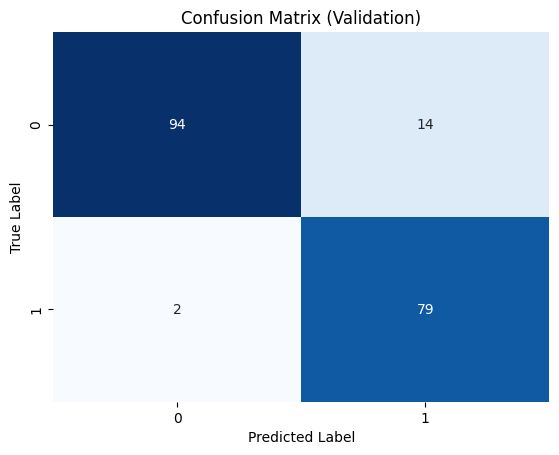

In [44]:
cm = confusion_matrix(y_validate, y_pred_validate)

# Visualization using Seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix (Validation)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [45]:
# Evaluate the performance on the unseen set
accuracy_unseen = accuracy_score(y_unseen, y_pred_unseen)
print(f"Accuracy on the unseen set with {num_features} features: {accuracy_unseen}")

Accuracy on the unseen set with 24 features: 0.907608695652174


In [46]:
# Print classification report for unseen set
classification_rep_unseen = classification_report(y_unseen, y_pred_unseen)
print("Classification Report on Unseen Set:")
print(classification_rep_unseen)

Classification Report on Unseen Set:
              precision    recall  f1-score   support

           0       0.89      0.92      0.91        90
           1       0.92      0.89      0.91        94

    accuracy                           0.91       184
   macro avg       0.91      0.91      0.91       184
weighted avg       0.91      0.91      0.91       184



# Confusion Matrix of Unseen

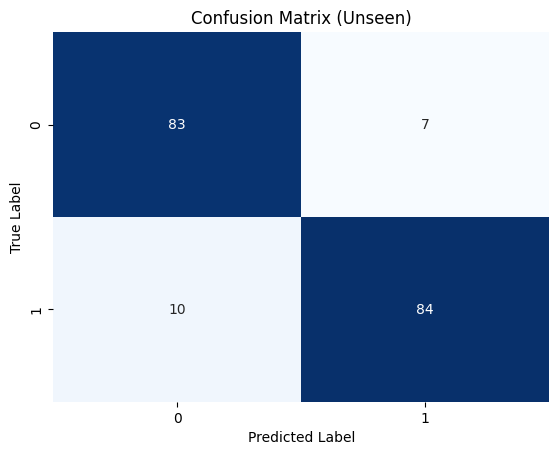

In [47]:

cm_unseen = confusion_matrix(y_unseen, y_pred_unseen)

# Visualization using Seaborn
sns.heatmap(cm_unseen, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix (Unseen)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()